# Surprise Housing Assignment
## Author: Kumaraguru Muthuraj
### Problem Statement
#### Surprise Housing wants to buy low and sell high of properties in Australia. They have data about sale prices of houses with ~80 features of homes. We want to find what features of homes affect the price the most.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Read the csv and shape it
housingDF = pd.read_csv("train.csv")

print(housingDF.shape)
housingDF.head()


(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
#Most of the columns have non-null data.
housingDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Do some cleanup and standardization of data.
#### A host of utility functions are created here.

In [4]:
#Drop the Id column
housingDF.drop(['Id'], inplace=True, axis=1)

In [5]:
#Lowercase the category column values
def lowerCaseCategoryColumns(df):
    cols = df.select_dtypes(include=['object']).columns
    for col in cols:
        df[col] = df[col].str.lower()    
    return

#Check the nulls in categorical columns and 
#print percentage of not-null values
def printCategoryColumnsPercentNNull(df):
    cols = df.select_dtypes(include=['object']).columns
    print("Category columns ", cols)
    print("Column count ", len(cols))

    colWithNull = 0
    for col in cols:
        total = df[col].size
        notNull = df[col].count()
        if  notNull != total:
            colWithNull += 1
            print('**********************')
            print('Column name ', col , '*** Percentage not null ', 100*notNull/total )
            print(' ')
            
    if colWithNull == 0:
        print("No columns have null values")

    return 

#Impute catagorical column Nulls with with 'none'
def imputeCategoryColumnNullsWithNone(df):
    cols = df.select_dtypes(include=['object']).columns
    print("Category columns ", cols)
    print("Column count ", len(cols))
    
    for col in cols:
        total = df[col].size
        notNull = df[col].count()
        if  notNull != total:
            df[col] = df[col].fillna("none")
    return

#Print percentage of nulls in numberic columns
def printNumericColsPercentNotNull(df):
    cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
    print("Numerical columns ", cols)
    print("Column count ", len(cols))

    colWithNull = 0
    for col in cols:
        total = df[col].size
        notNull = df[col].count()
        if  notNull != total:
            colWithNull += 1
            print('**********************')
            print('Column name ', col , '*** Percentage not null ', 100*notNull/total )
            print(' ')
    
    if colWithNull == 0:
        print("No columns have null values")

    return 

#Impute numeric columns with 'Median' for Nulls
def imputeNumericColumnNullsWithMedian(df):
    cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
    print("Numerical columns ", cols)
    print("Column count ", len(cols))
    
    for col in cols:
        total = df[col].size
        notNull = df[col].count()
        if  notNull != total:
            df[col] = df[col].fillna(df[col].median())
    return

#Util function that gets the lower and upper fence for numberic 
#columns. This will be used to cap outliers.
def getLowerAndUpperFence(df, col):
    q1 = np.quantile(df[col], .25)
    q3 = np.quantile(df[col], .75)
    base = (q3 - q1) * 1.5
    lFen  = q1 - base
    uFen = q3 + base
    return (lFen, uFen)

#Get percentage of outliers below and above fences.
def getPercentOfOutliers(df, col, l, u):
    lFilter = df[col] < l
    uFilter = df[col] > u
    
    low = df[lFilter] 
    high = df[uFilter]
    
    lPer = 100*len(low) / len(df)
    hPer = 100*len(high) / len(df)
    
    return (lPer, hPer)

#Util function to cap by k(=5 default)%
#We cap outliers by setting them to fence+5%IQR or fence-5%IQR 
def capper(x, l, u):
    k = 5
    kpercent = (k / 100)
    if x < l:
        return (l - kpercent * (u - l))
    elif u < x:
        return (u + kpercent * (u - l))        
    return x

#Cap lower and upper limit
def capLowerAndUpperLimit(df, col, l, u):
    df[col] = df[col].apply(capper, args=(l, u))
    return

#Check outliers in numeric columns - print percent of 
#low and high outliers for each column
def checkOutliersInNumericColumns(df, cols):
    if len(cols) == 0:
        cols = df.select_dtypes(include=['int64', 'int32', 'float64']).columns
    
    print("Numerical columns ", cols)
    print("Column count ", len(cols))
    
    for col in cols:        
        plt.figure(figsize=(14, 5))

        plt.subplot(1,2,1)
        sns.boxplot(df[col])
        plt.title(col, fontsize=14)
        
        plt.subplot(1,2,2)
        plt.hist(df[col])
        plt.title(col, fontsize=14)
        
        plt.show()
        
        l, u = getLowerAndUpperFence(housingDF, col)
        lp, hp = getPercentOfOutliers(housingDF, col, l, u)
        
        print(col, " - Percent of outliers below lower fence ", lp, " and above upper fence ", hp)        
    return

#Pass a list of numeric column names that you want to cap up to k% of IQR
def capNumericColumnOutliers(df, cols):
    for col in cols:
        l, u = getLowerAndUpperFence(df, col)
        capLowerAndUpperLimit(df, col, l, u)
    return

# Importing the required libraries for plots.
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Residual analysis - Plots distribution, variance and patterns
def residualAnalysis(yTrain, yTrainPred, logTxt):
    print(logTxt)
    # Plot the histogram of the error terms
    fig = plt.figure()
    fig.suptitle('Distribution of errors', fontsize = 12)
    res = (yTrain - yTrainPred)
    sns.distplot(res, bins = 20)
    plt.show()
    
    # Variance of error terms
    c = [i for i in range(1, len(res) + 1, 1)]
    plt.scatter(c, res)
    plt.title("Homoscedastic variance?", fontsize = 12)
    sns.regplot(x=c, y=res, line_kws={'color': 'yellow'})
    plt.show()
    
    plt.scatter(yTrainPred , res)
    plt.axhline(y=0, color='r', linestyle=':')
    plt.title("Pattern in residues?", fontsize = 12)
    plt.xlabel("Sales Price Predictions")
    plt.ylabel("Residual")
    plt.show()
    
    return

#Predicts the Ys for XTrain and XTest - Calculates the scores.
def predictAndDisplayScores(algorithm, XTrain, yTrain, XTest, yTest, logTxt):
    print(logTxt)

    print('**********XTrain columns ', len(XTrain.columns))
    print('**********XTest columns ', len(XTest.columns))
    
    results = {}
    yPredTrain = algorithm.predict(XTrain)
    yPredTest = algorithm.predict(XTest)

    results['YPredTrain'] = yPredTrain
    results['YPredTest'] = yPredTest
    
    metric = {}
    
    r2_train_lr = r2_score(yTrain, yPredTrain)
    metric['R2Train'] = r2_train_lr

    r2_test_lr = r2_score(yTest, yPredTest)
    metric['R2Test'] = r2_test_lr

    rss1_lr = np.sum(np.square(yTrain - yPredTrain))
    metric['RSSTrain'] = rss1_lr

    rss2_lr = np.sum(np.square(yTest - yPredTest))
    metric['RSSTest'] = rss2_lr

    mse_train_lr = mean_squared_error(yTrain, yPredTrain)
    RMSE_tr = mse_train_lr**0.5
    metric['MSETrain'] = mse_train_lr
    metric['RMSETrain'] = RMSE_tr

    mse_test_lr = mean_squared_error(yTest, yPredTest)
    RMSE_te = mse_test_lr**0.5
    metric['MSETest'] = mse_test_lr
    metric['RMSETest'] = RMSE_te
    
    results['metric'] = metric

    return results

#Used to do a Linear Regression fit, before an RFE.
#Use LRFitAndAnalyze() to reduce features one-by-one and do LR fit.
def primitiveLRFitAndAnalyze(XTrain, yTrain, XTest, yTest):
    linearModel = LinearRegression()
    linearModel.fit(X_train, y_train)
    
    # TRAIN DATA PREDICTIONS
    # Making predictions
    yTrainPred = linearModel.predict(XTrain)
    
    # TRAIN DATA RESIDUAL ANALYSIS
    residualAnalysis(yTrain, yTrainPred, '***Linear regression training data residual analysis***')
    ##########################################
    
    # TEST DATA PREDICTIONS
    # Making predictions
    yTestPred = linearModel.predict(XTest)
    
    # Publish scores. Looks very good, but the difference in R2 between train and test is large
    results = predictAndDisplayScores(linearModel, XTrain, yTrain, XTest, yTest, \
                                      "****Scores of primitive Linear regression****")

    YPredTrain = results.get('YPredTrain') 
    YPredTest = results.get('YPredTest')
    metrics = results.get('metric')

    #print("Y Predicted train\n", YPredTrain)
    #print("Y Predicted test\n", YPredTest)
    print("Metrics\n", metrics)
    return linearModel


#RFE and return the Top VIF column to be removed.
#Note that rule is to use p-value first and then VIF.
#We choose to use VIF because there are quite with Infinite VIF values,
#that we want to remove.
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
def doRFEAndReturnTopVIFColumn(y_train, X_train_rfe):
    X_train_rfe = sm.add_constant(X_train_rfe)
    # Running the linear model
    lm = sm.OLS(y_train, X_train_rfe).fit()
    #Let's see the summary of our linear model
    print(lm.summary())
    
    # Calculate the VIFs for the new model
    vif = pd.DataFrame()
    X = X_train_rfe
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    
    pd.set_option('display.max_rows', None)
    print(vif)
    #If 'const' is top on list get next one
    colName = vif.iloc[0]['Features']
    if colName == 'const':
        colName = vif.iloc[1]['Features']
    return (colName, lm)

#Given X and y train and test, does a Linear Regression fit
#Predicts, does residual analysis, prints accuracy and predictive power scores.
#Use this after RFE
import statsmodels.api as statsModAPI
def LRFitAndAnalyze(XTrain, yTrain, XTest, yTest):    
    linearModel = LinearRegression()
    
    # Adding a constant variable 
    #XTrain = statsModAPI.add_constant(XTrain)
    linearModel.fit(XTrain, yTrain)
    
    # TRAIN DATA PREDICTIONS
    #X_train_no_const = X_train_rfe.drop(['const'], axis=1)
    # Making predictions
    yTrainPred = linearModel.predict(XTrain)
    
    # TRAIN DATA RESIDUAL ANALYSIS
    residualAnalysis(yTrain, yTrainPred, '***Linear regression training data residual analysis***')
    
    ##########################################
    
    # TEST DATA PREDICTIONS
    #X_train_no_const = X_train_rfe.drop(['const'], axis=1)

    # Adding a constant variable 
    #XTest = statsModAPI.add_constant(XTest)
    # Making predictions
    yTestPred = linearModel.predict(XTest)
    
    # TEST DATA RESIDUAL ANALYSIS
    residualAnalysis(yTest, yTestPred, '***Linear regression test data residual analysis***')
    
    # Publish scores. Looks very good, but the difference in R2 between train and test is large
    results = predictAndDisplayScores(linearModel, XTrain, yTrain, XTest, yTest, \
                                      "****Scores of Linear regression after RFE****")
    
    YPredTrain = results.get('YPredTrain') 
    YPredTest = results.get('YPredTest')
    metrics = results.get('metric')

    #print("Y Predicted train\n", YPredTrain)
    #print("Y Predicted test\n", YPredTest)
    print("Metrics\n", metrics)
    return linearModel

#### Convert categorical values to lower case - standardize.
#### Print percentage of non-null values in categorical columns and decide which ones to drop.

In [6]:
lowerCaseCategoryColumns(housingDF)
printCategoryColumnsPercentNNull(housingDF)

Category columns  Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')
Column count  43
**********************
Column name  Alley *** Percentage not null  6.232876712328767
 
**********************
Column name  MasVnrType *** Percentage not null  99.45205479452055
 
**********************
Column name  BsmtQual *** Percentage not null  97.46575342465754
 
**********************
Column n

In [7]:
housingDF[housingDF.select_dtypes(include=['object']).columns].head()

MSZoning Street Alley LotShape LandContour Utilities LotConfig LandSlope  \
0       rl   pave   NaN      reg         lvl    allpub    inside       gtl   
1       rl   pave   NaN      reg         lvl    allpub       fr2       gtl   
2       rl   pave   NaN      ir1         lvl    allpub    inside       gtl   
3       rl   pave   NaN      ir1         lvl    allpub    corner       gtl   
4       rl   pave   NaN      ir1         lvl    allpub       fr2       gtl   

  Neighborhood Condition1  ... GarageType GarageFinish GarageQual GarageCond  \
0      collgcr       norm  ...     attchd          rfn         ta         ta   
1      veenker      feedr  ...     attchd          rfn         ta         ta   
2      collgcr       norm  ...     attchd          rfn         ta         ta   
3      crawfor       norm  ...     detchd          unf         ta         ta   
4      noridge       norm  ...     attchd          rfn         ta         ta   

  PavedDrive PoolQC Fence MiscFeature SaleType SaleCondition  
0          y    NaN   NaN         NaN       wd        normal  
1          y    NaN   NaN         NaN       wd        normal  
2          y    NaN   NaN         NaN       wd        normal  
3          y    NaN   NaN         NaN       wd       abnorml  
4          y    NaN   NaN         NaN       wd        normal  

[5 rows x 43 columns]

In [8]:
#Drop 'Alley', 'PoolQC' and 'MiscFeature' column because they have very high null values
dropNullValCols = ['Alley', 'PoolQC', 'MiscFeature']
housingDF.drop(dropNullValCols, inplace=True, axis=1)

#Impute nulls and check for nulls
imputeCategoryColumnNullsWithNone(housingDF)
#Check if nulls still exist in categorical columns
printCategoryColumnsPercentNNull(housingDF)

Category columns  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')
Column count  40
Category columns  Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond

In [9]:
#Print percentage of nulls in nuerical columns
#Impute them with median
printNumericColsPercentNotNull(housingDF)
imputeNumericColumnNullsWithMedian(housingDF)

Numerical columns  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Column count  37
**********************
Column name  LotFrontage *** Percentage not null  82.26027397260275
 
**********************
Column name  MasVnrArea *** Percentage not null  99.45205479452055
 
**********************
Column name  GarageYrBlt *** Percentage not null  94.45205479452055
 
Numerical columns  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond'

In [10]:
#Convert year and month fields to int to avoid decimal places
#Year can be categorical, but we choose to see it as numerical.
#Year can be seen as ordinal and age of property can be realized.
housingDF.YearBuilt = housingDF.YearBuilt.astype('int')
housingDF.YearRemodAdd = housingDF.YearRemodAdd.astype('int')
housingDF.MoSold = housingDF.MoSold.astype('int')
housingDF.YrSold = housingDF.YrSold.astype('int')
housingDF.GarageYrBlt = housingDF.GarageYrBlt.astype('int')

In [11]:
#Check if any columns still have nulls before doing EDA
printNumericColsPercentNotNull(housingDF)

Numerical columns  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Column count  37
No columns have null values


Numerical columns  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')
Column count  37


MSSubClass  - Percent of outliers below lower fence  0.0  and above upper fence  7.054794520547945


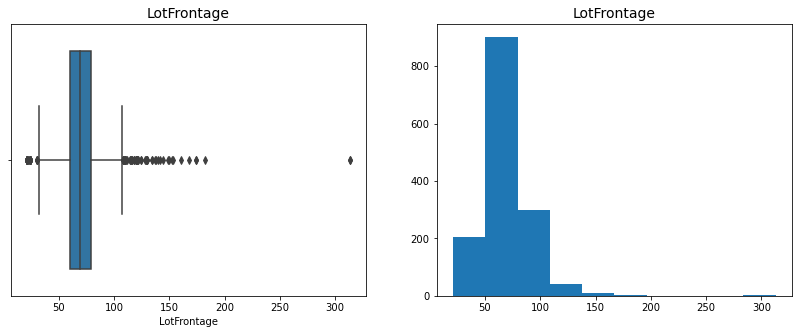

LotFrontage  - Percent of outliers below lower fence  3.287671232876712  and above upper fence  3.9726027397260273


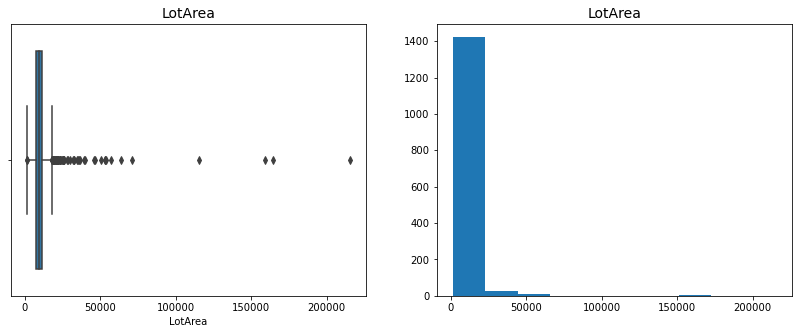

LotArea  - Percent of outliers below lower fence  0.136986301369863  and above upper fence  4.589041095890411


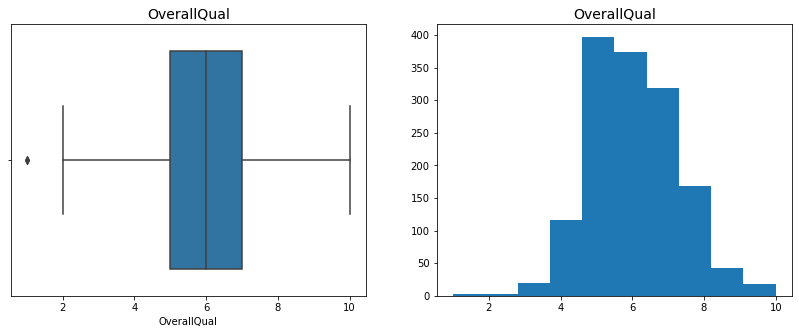

OverallQual  - Percent of outliers below lower fence  0.136986301369863  and above upper fence  0.0


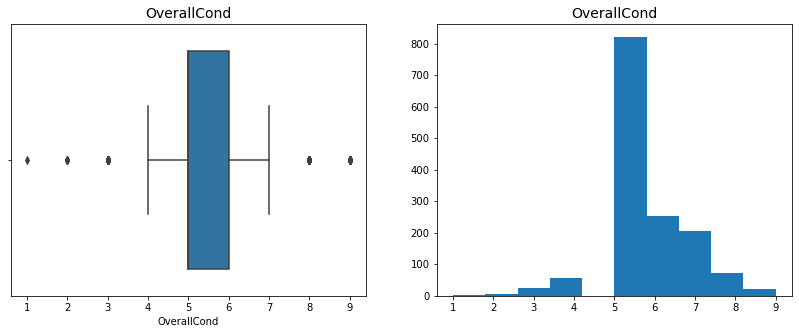

OverallCond  - Percent of outliers below lower fence  2.1232876712328768  and above upper fence  6.438356164383562


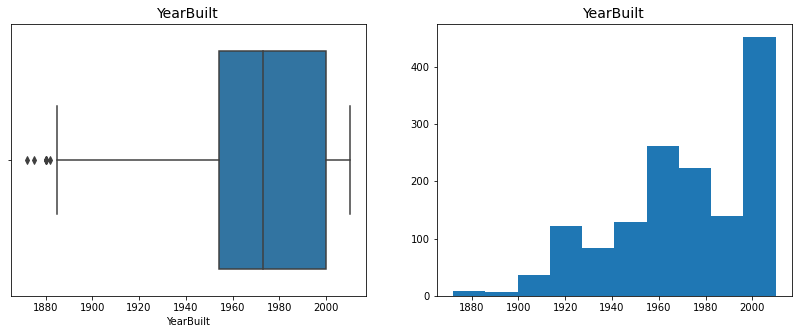

YearBuilt  - Percent of outliers below lower fence  0.4794520547945205  and above upper fence  0.0


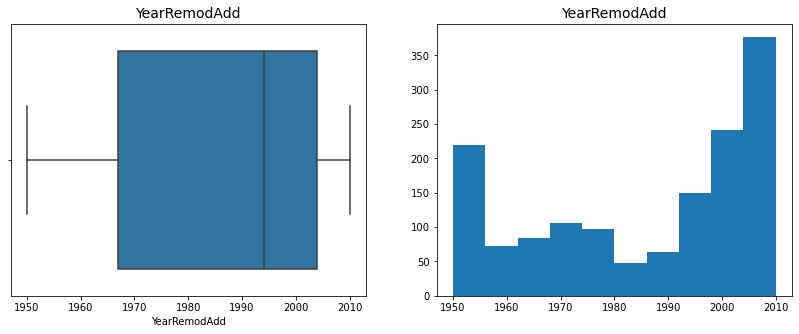

YearRemodAdd  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


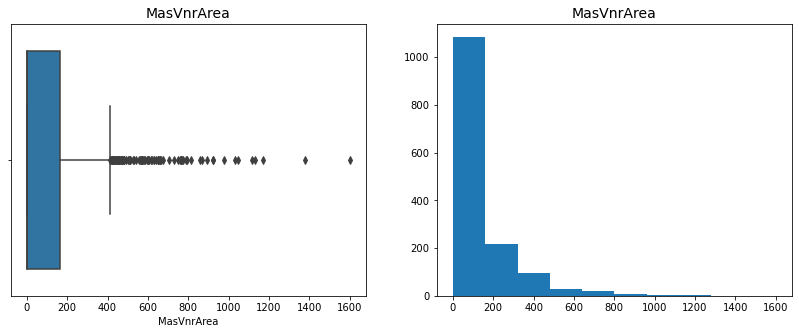

MasVnrArea  - Percent of outliers below lower fence  0.0  and above upper fence  6.712328767123288


BsmtFinSF1  - Percent of outliers below lower fence  0.0  and above upper fence  0.4794520547945205


BsmtFinSF2  - Percent of outliers below lower fence  0.0  and above upper fence  11.438356164383562


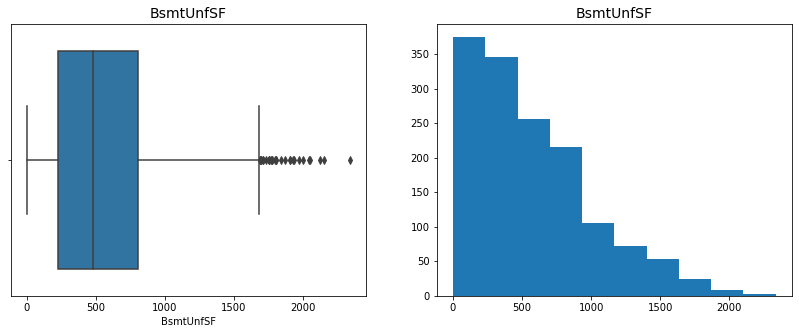

BsmtUnfSF  - Percent of outliers below lower fence  0.0  and above upper fence  1.9863013698630136


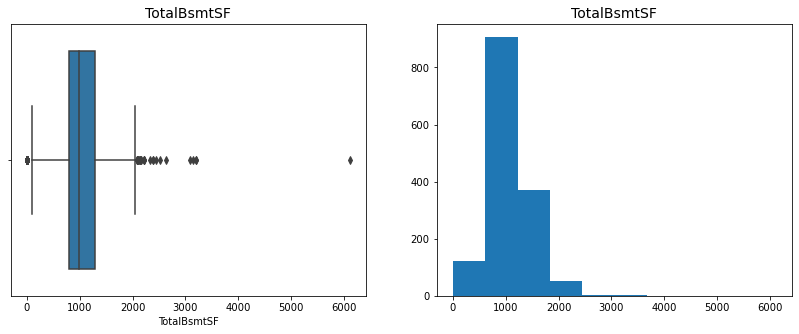

TotalBsmtSF  - Percent of outliers below lower fence  2.5342465753424657  and above upper fence  1.643835616438356


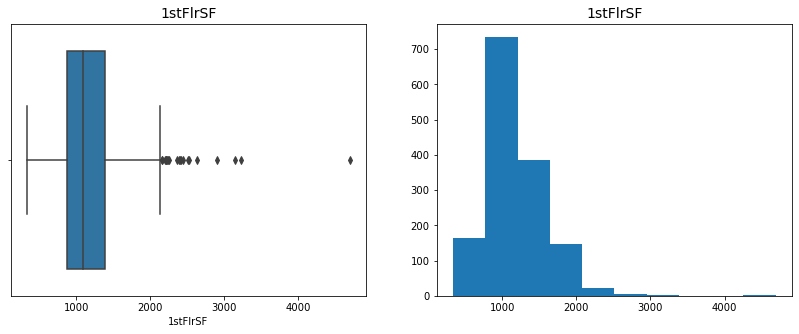

1stFlrSF  - Percent of outliers below lower fence  0.0  and above upper fence  1.36986301369863


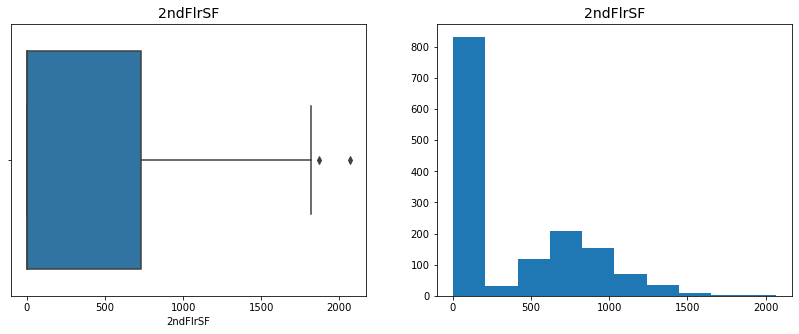

2ndFlrSF  - Percent of outliers below lower fence  0.0  and above upper fence  0.136986301369863


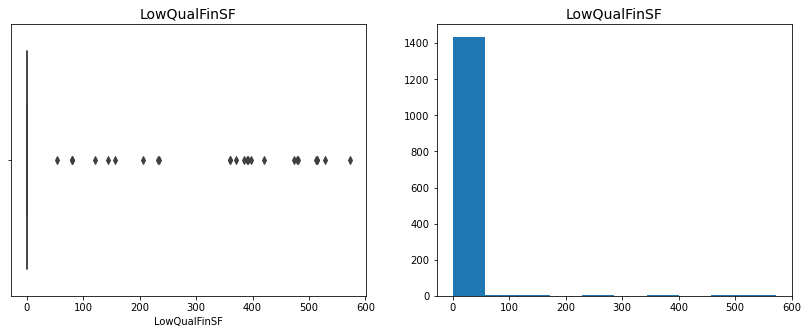

LowQualFinSF  - Percent of outliers below lower fence  0.0  and above upper fence  1.7808219178082192


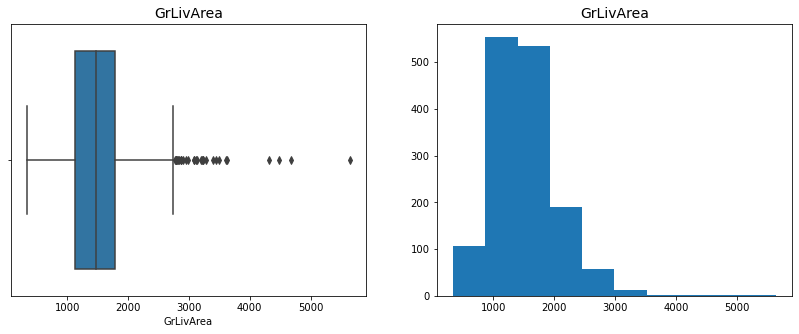

GrLivArea  - Percent of outliers below lower fence  0.0  and above upper fence  2.1232876712328768


BsmtFullBath  - Percent of outliers below lower fence  0.0  and above upper fence  0.0684931506849315


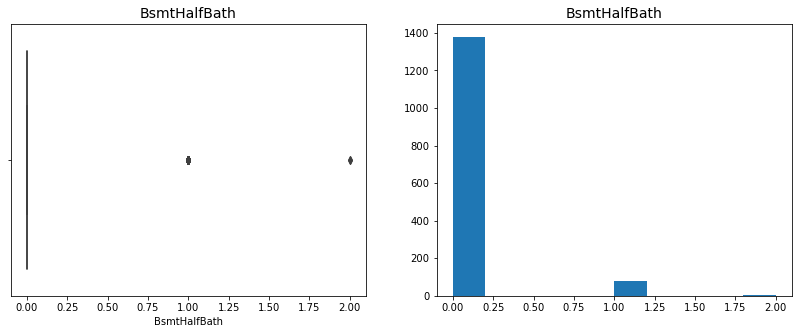

BsmtHalfBath  - Percent of outliers below lower fence  0.0  and above upper fence  5.616438356164384


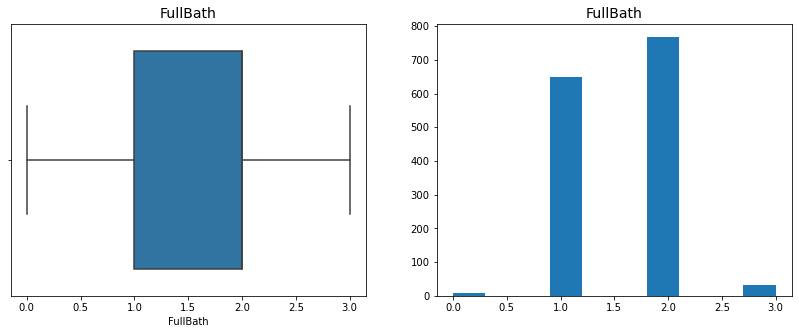

FullBath  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


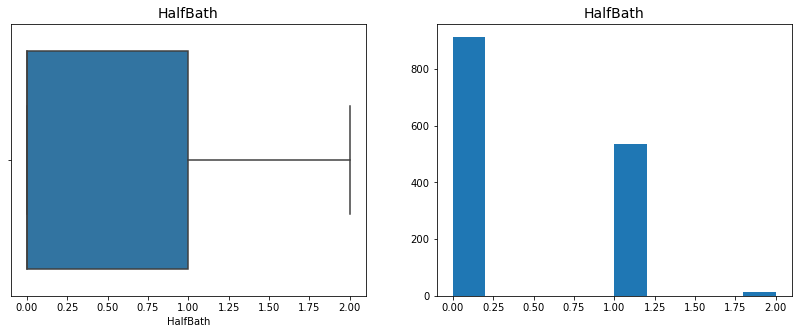

HalfBath  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


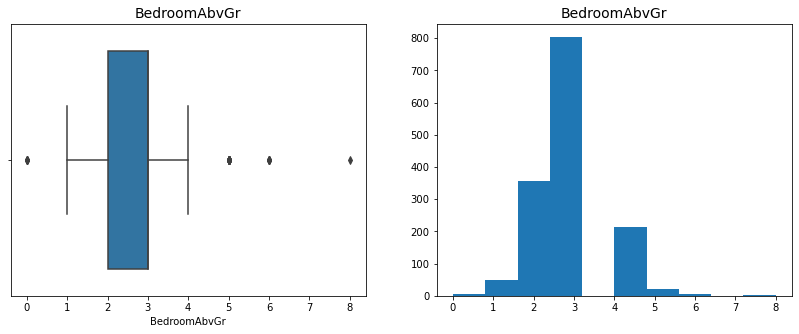

BedroomAbvGr  - Percent of outliers below lower fence  0.410958904109589  and above upper fence  1.9863013698630136


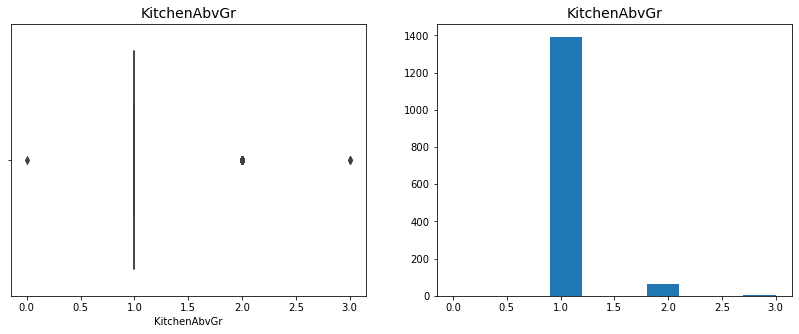

KitchenAbvGr  - Percent of outliers below lower fence  0.0684931506849315  and above upper fence  4.589041095890411


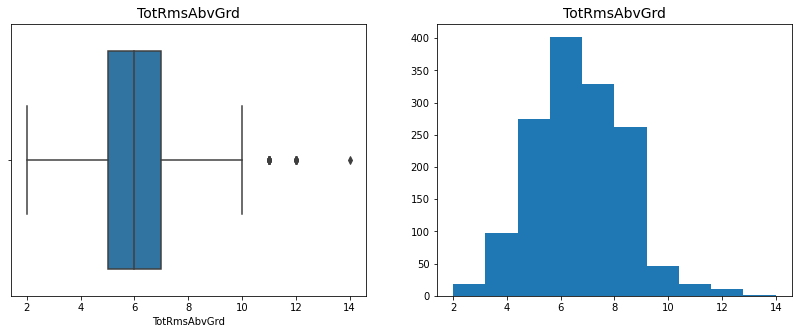

TotRmsAbvGrd  - Percent of outliers below lower fence  0.0  and above upper fence  2.0547945205479454


Fireplaces  - Percent of outliers below lower fence  0.0  and above upper fence  0.3424657534246575


GarageYrBlt  - Percent of outliers below lower fence  0.0684931506849315  and above upper fence  0.0


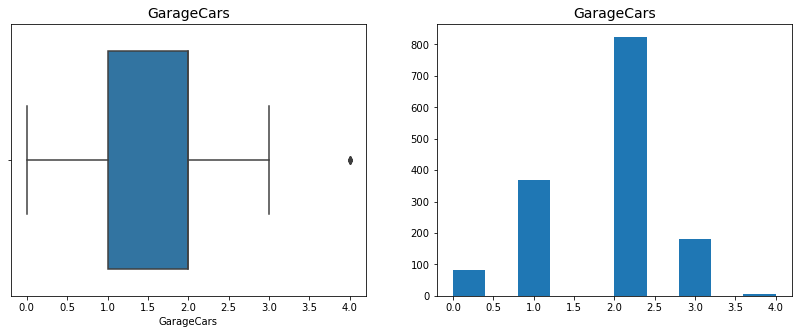

GarageCars  - Percent of outliers below lower fence  0.0  and above upper fence  0.3424657534246575


GarageArea  - Percent of outliers below lower fence  0.0  and above upper fence  1.4383561643835616


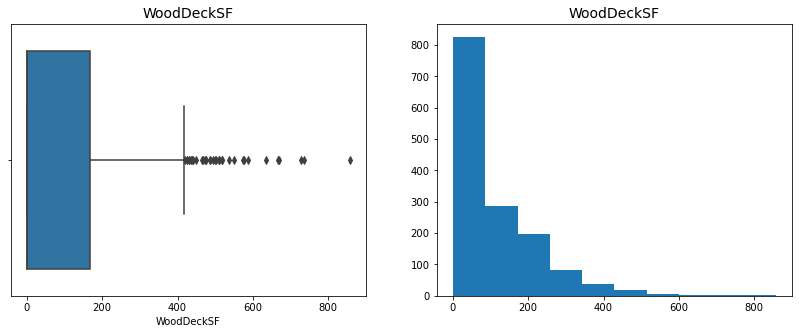

WoodDeckSF  - Percent of outliers below lower fence  0.0  and above upper fence  2.191780821917808


OpenPorchSF  - Percent of outliers below lower fence  0.0  and above upper fence  5.273972602739726


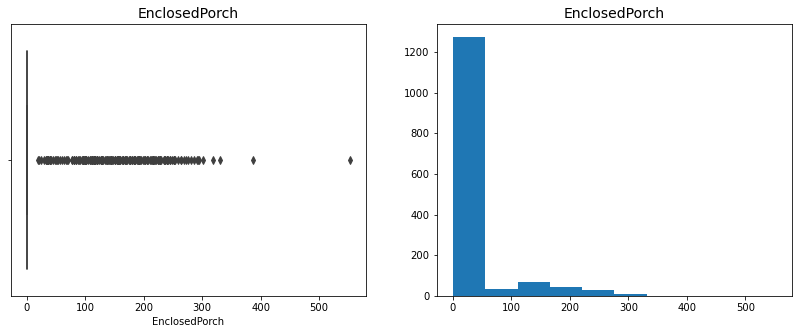

EnclosedPorch  - Percent of outliers below lower fence  0.0  and above upper fence  14.246575342465754


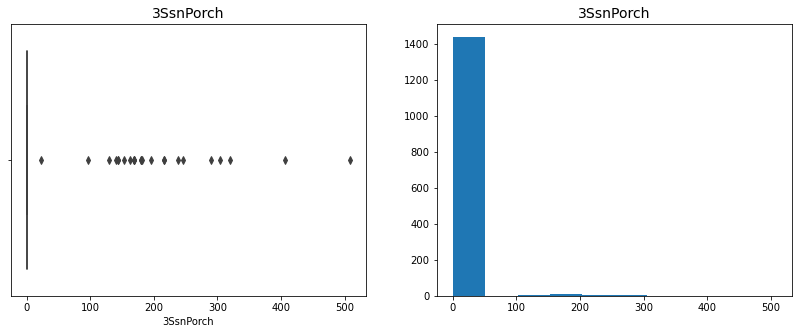

3SsnPorch  - Percent of outliers below lower fence  0.0  and above upper fence  1.643835616438356


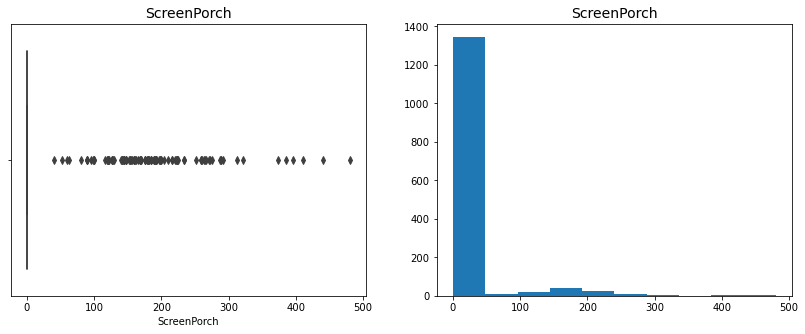

ScreenPorch  - Percent of outliers below lower fence  0.0  and above upper fence  7.945205479452055


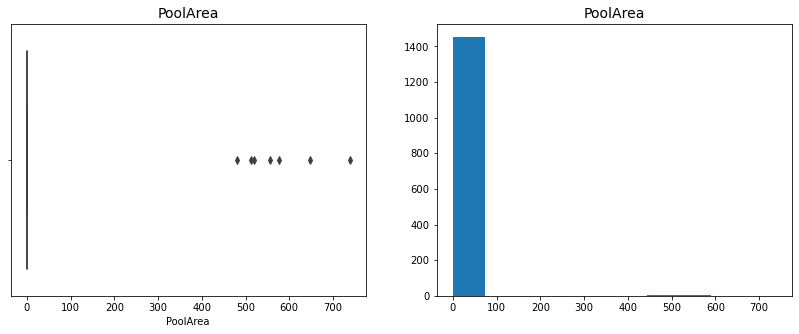

PoolArea  - Percent of outliers below lower fence  0.0  and above upper fence  0.4794520547945205


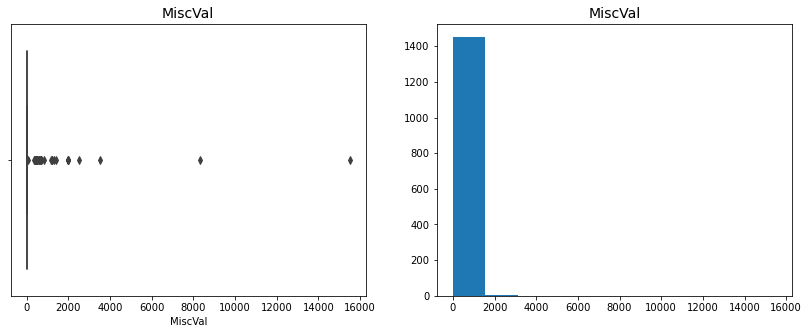

MiscVal  - Percent of outliers below lower fence  0.0  and above upper fence  3.5616438356164384


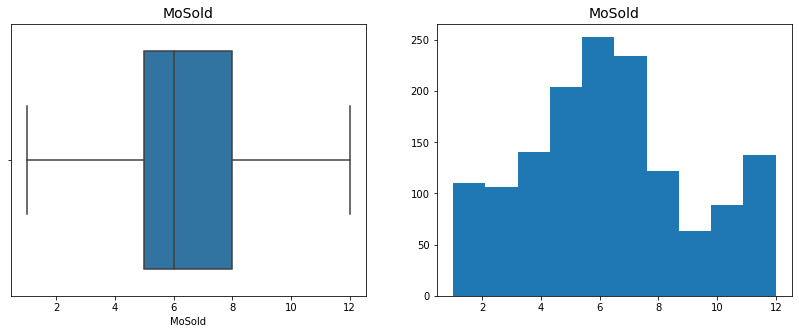

MoSold  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


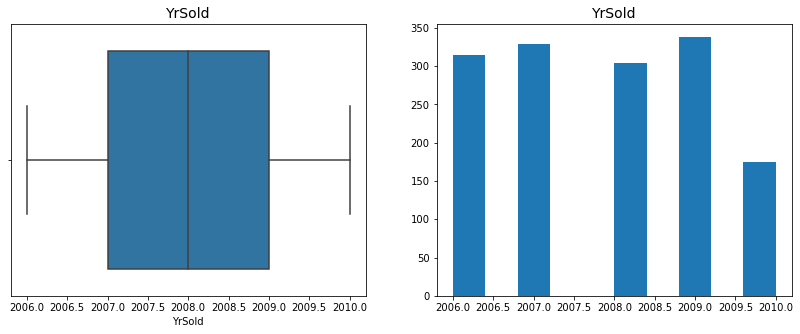

YrSold  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


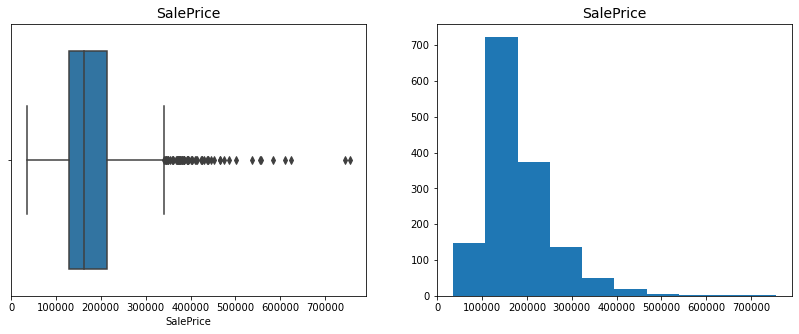

SalePrice  - Percent of outliers below lower fence  0.0  and above upper fence  4.178082191780822


In [12]:
#For each numerical column, box plot to check outliers and highly repeated values with histograms.
#Eyeball the chart and decide which of these should be dropped and those that need outlier treatment.
checkOutliersInNumericColumns(housingDF, [])

In [13]:
#Columns that had a very high repetition of values and indicated by the histogram and box plot with IQR appearing
#as vertical line are to be removed. They have no impact on sale price.
dropColumns = ['LotArea', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', 'KitchenAbvGr', 'EnclosedPorch', \
               '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

housingDF.drop(dropColumns, inplace=True, axis=1)

In [14]:
#Outlier treatment by capping them
columnsToCap = ['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', \
                'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',\
                'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',\
                'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',\
                'OpenPorchSF',  'MoSold', 'YrSold']

capNumericColumnOutliers(housingDF, columnsToCap)

Numerical columns  ['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MoSold', 'YrSold']
Column count  26


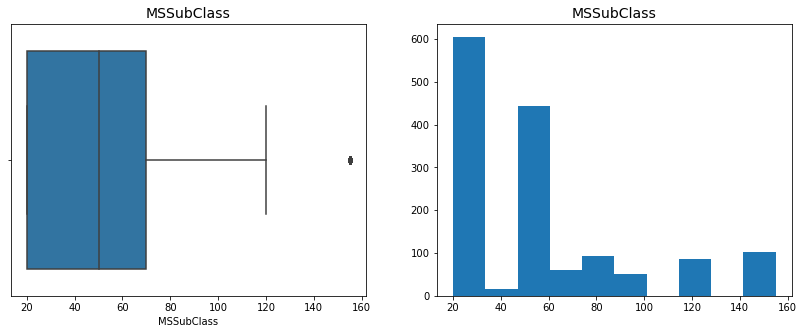

MSSubClass  - Percent of outliers below lower fence  0.0  and above upper fence  7.054794520547945


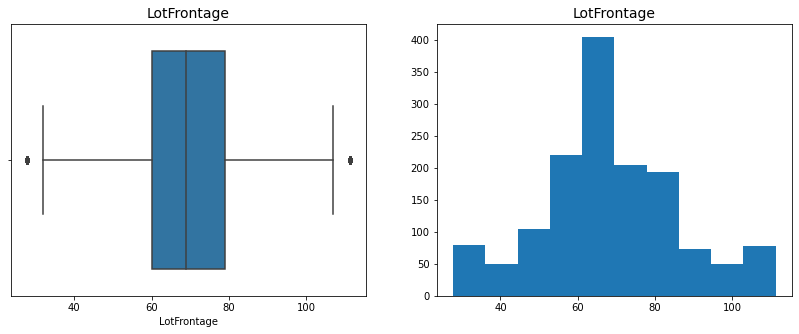

LotFrontage  - Percent of outliers below lower fence  3.287671232876712  and above upper fence  3.9726027397260273


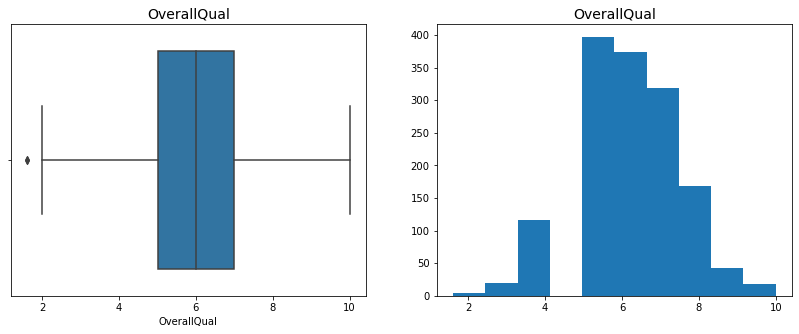

OverallQual  - Percent of outliers below lower fence  0.136986301369863  and above upper fence  0.0


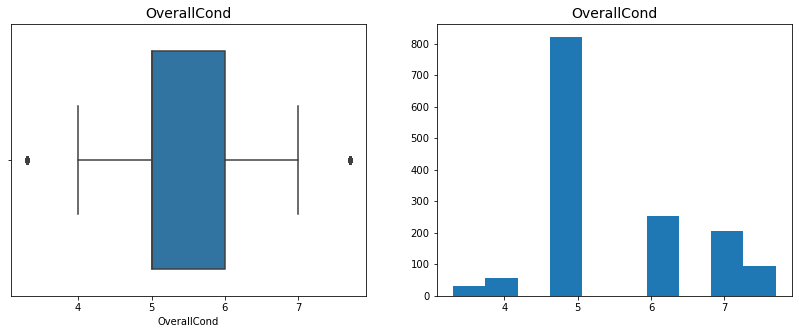

OverallCond  - Percent of outliers below lower fence  2.1232876712328768  and above upper fence  6.438356164383562


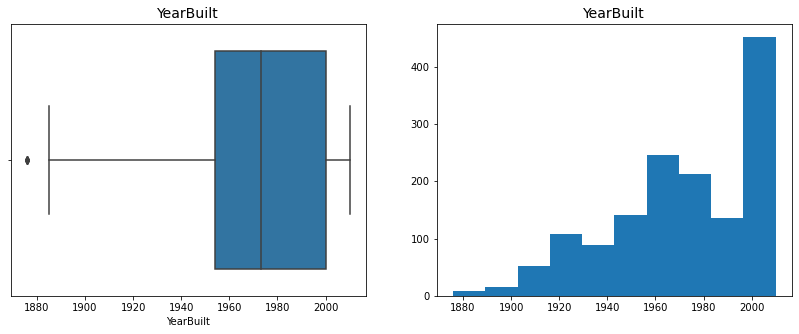

YearBuilt  - Percent of outliers below lower fence  0.4794520547945205  and above upper fence  0.0


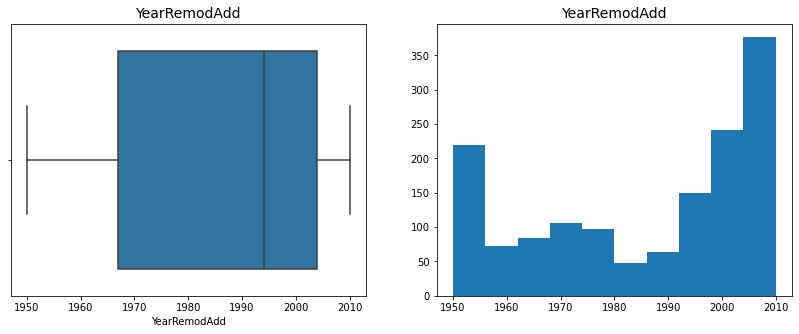

YearRemodAdd  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


MasVnrArea  - Percent of outliers below lower fence  0.0  and above upper fence  6.712328767123288


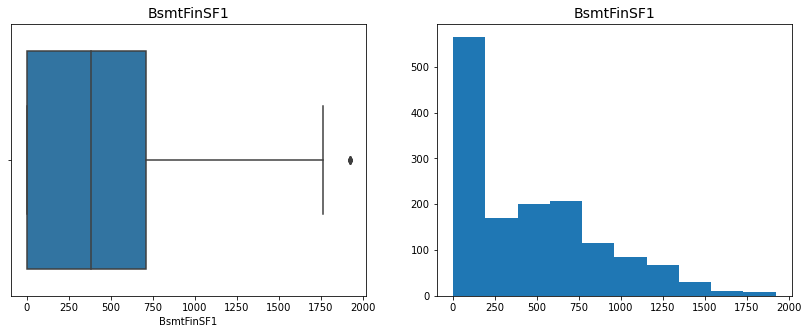

BsmtFinSF1  - Percent of outliers below lower fence  0.0  and above upper fence  0.4794520547945205


BsmtUnfSF  - Percent of outliers below lower fence  0.0  and above upper fence  1.9863013698630136


TotalBsmtSF  - Percent of outliers below lower fence  2.5342465753424657  and above upper fence  1.643835616438356


1stFlrSF  - Percent of outliers below lower fence  0.0  and above upper fence  1.36986301369863


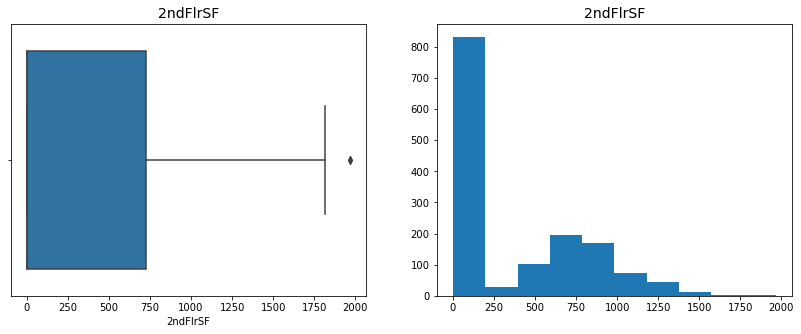

2ndFlrSF  - Percent of outliers below lower fence  0.0  and above upper fence  0.136986301369863


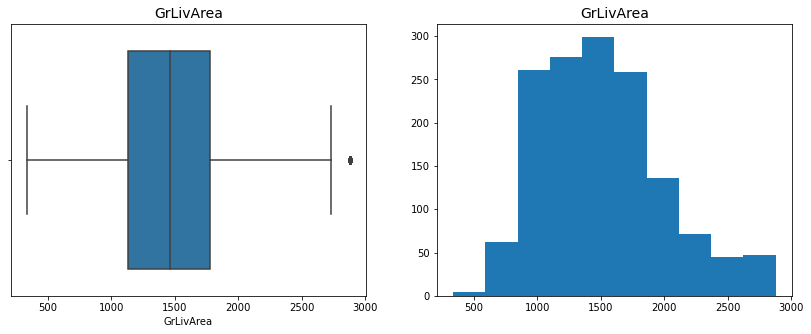

GrLivArea  - Percent of outliers below lower fence  0.0  and above upper fence  2.1232876712328768


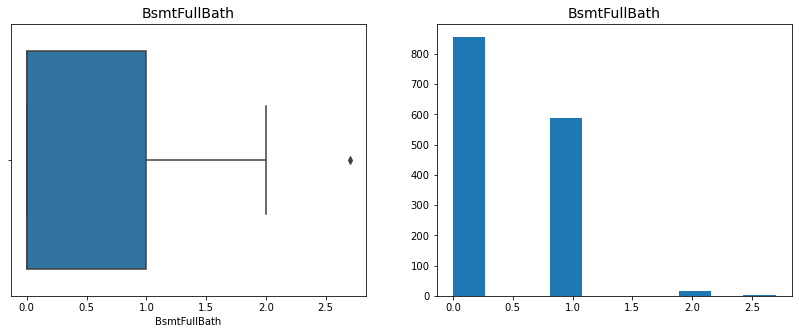

BsmtFullBath  - Percent of outliers below lower fence  0.0  and above upper fence  0.0684931506849315


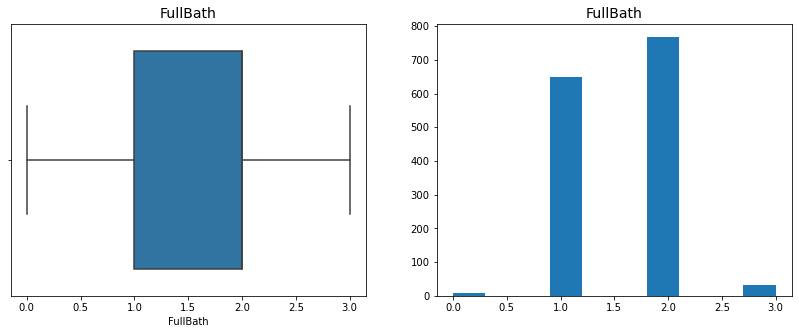

FullBath  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


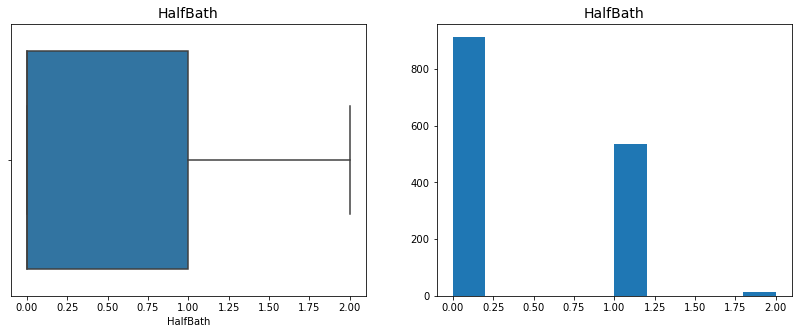

HalfBath  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


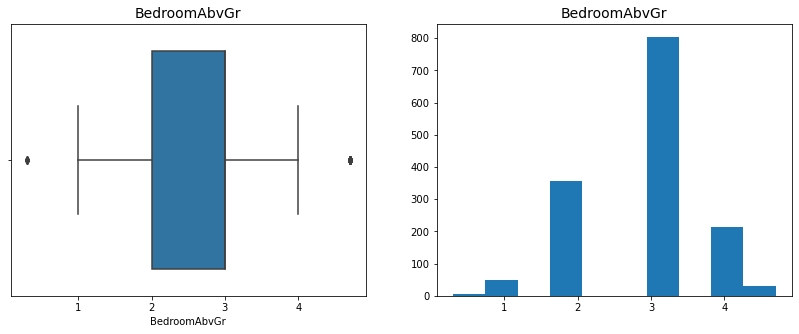

BedroomAbvGr  - Percent of outliers below lower fence  0.410958904109589  and above upper fence  1.9863013698630136


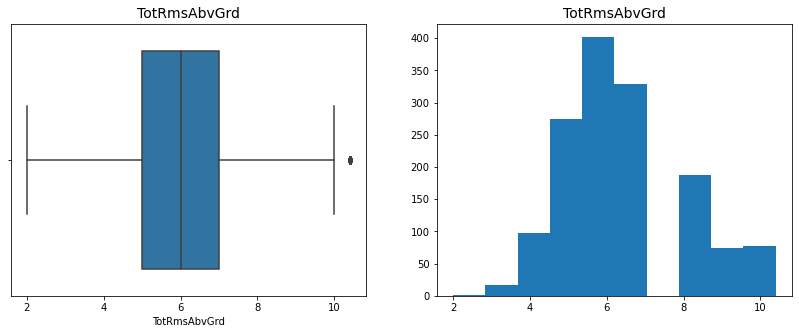

TotRmsAbvGrd  - Percent of outliers below lower fence  0.0  and above upper fence  2.0547945205479454


Fireplaces  - Percent of outliers below lower fence  0.0  and above upper fence  0.3424657534246575


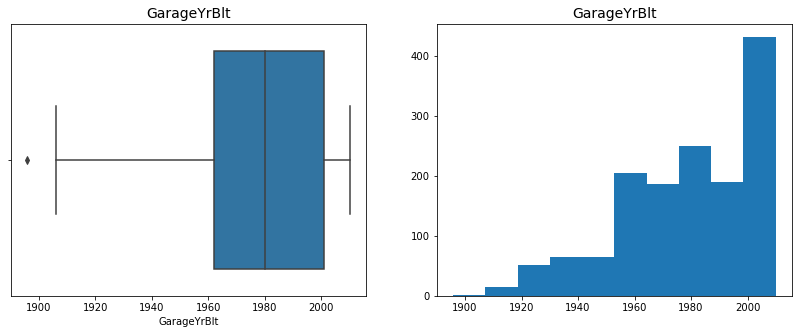

GarageYrBlt  - Percent of outliers below lower fence  0.0684931506849315  and above upper fence  0.0


GarageCars  - Percent of outliers below lower fence  0.0  and above upper fence  0.3424657534246575


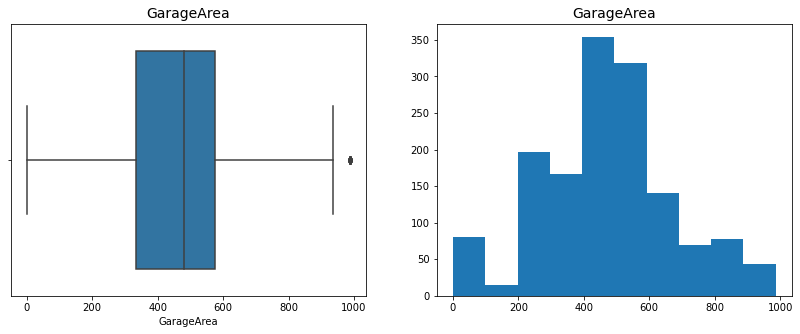

GarageArea  - Percent of outliers below lower fence  0.0  and above upper fence  1.4383561643835616


WoodDeckSF  - Percent of outliers below lower fence  0.0  and above upper fence  2.191780821917808


OpenPorchSF  - Percent of outliers below lower fence  0.0  and above upper fence  5.273972602739726


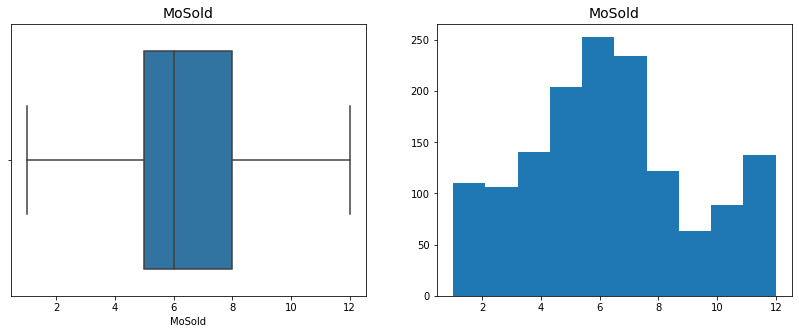

MoSold  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


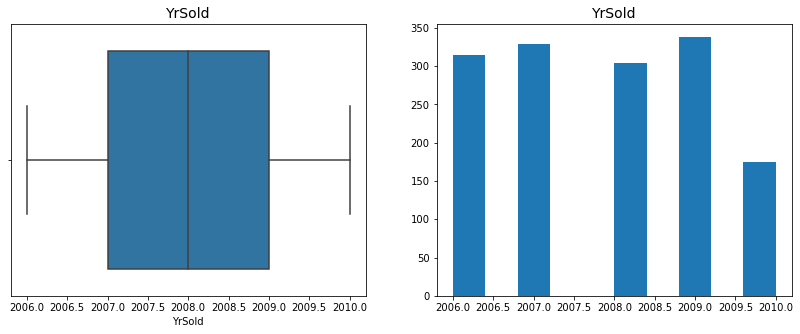

YrSold  - Percent of outliers below lower fence  0.0  and above upper fence  0.0


In [15]:
#Not really checking outliers, but we want to visually see if there is any shift in fence values.
#Did capping really work?
#No columns with very high repetitions.
checkOutliersInNumericColumns(housingDF, columnsToCap)

In [16]:
#Get all numeric columns to apply MinMax Scaler
#This is only for scaling purpose and for nothing else
tDF = housingDF.select_dtypes(include=['int32', 'int64', 'float64'])
numericCols2Scale = list(tDF.columns)

In [17]:
#Add dummy columns for categorical columns
category_cols = housingDF.select_dtypes(include=['object']).columns
dummyCols = pd.get_dummies(housingDF[category_cols], drop_first = True)

housingDF = pd.concat([housingDF, dummyCols], axis = 1)
housingDF.drop(list(category_cols), axis = 1, inplace = True)

In [18]:
housingDF.columns

Index(['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_conlw', 'SaleType_cwd', 'SaleType_new', 'SaleType_oth',
       'SaleType_wd', 'SaleCondition_adjland', 'SaleCondition_alloca',
       'SaleCondition_family', 'SaleCondition_normal',
       'SaleCondition_partial'],
      dtype='object', length=242)

### Note that we didn't do correlation matrix specifically because with high number of columns it becomes difficult to interpret. Our objective is to remove unnecessary columns and get in to RFE. We eliminated quite a lot, with light EDA with box plot and histograms.

####  Split train and test

In [19]:
from sklearn.model_selection import train_test_split

# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(housingDF, train_size = 0.7, test_size = 0.3, random_state = 100)

#### Apply MinMaxScaler to all the numeric variables

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Apply scaler() to all the Feature - X vars (that are numeric)
#Train data scaling
df_train[numericCols2Scale] = scaler.fit_transform(df_train[numericCols2Scale])
#Test data scaling
df_test[numericCols2Scale] = scaler.transform(df_test[numericCols2Scale])

In [21]:
#Separate train data features and target (X and y)
y_train = df_train.pop('SalePrice')
X_train = df_train

#Separate test data features and target (X and y)
y_test = df_test.pop('SalePrice')
X_test = df_test

In [22]:
df_train.head()

MSSubClass  LotFrontage  OverallQual  OverallCond  YearBuilt  \
210     0.074074     0.470096     0.404762     0.613636   0.366617   
318     0.296296     0.745215     0.642857     0.386364   0.873323   
239     0.222222     0.290670     0.523810     0.159091   0.515648   
986     0.222222     0.374402     0.523810     1.000000   0.254844   
1416    1.000000     0.386364     0.285714     0.613636   0.068554   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  ...  \
210       0.000000    0.000000    0.243360   0.219695     0.417232  ...   
318       0.716667    0.577259    0.513241   0.199723     0.635685  ...   
239       0.000000    0.000000    0.048880   0.355617     0.358887  ...   
986       0.883333    0.000000    0.000000   0.269071     0.245816  ...   
1416      0.000000    0.000000    0.000000   0.431068     0.377883  ...   

      SaleType_conlw  SaleType_cwd  SaleType_new  SaleType_oth  SaleType_wd  \
210                0             0             0             0            1   
318                0             0             0             0            1   
239                0             0             0             0            1   
986                0             0             0             0            1   
1416               0             0             0             0            1   

      SaleCondition_adjland  SaleCondition_alloca  SaleCondition_family  \
210                       0                     0                     0   
318                       0                     0                     0   
239                       0                     0                     0   
986                       0                     0                     0   
1416                      0                     0                     0   

      SaleCondition_normal  SaleCondition_partial  
210                      1                      0  
318                      1                      0  
239                      1                      0  
986                      1                      0  
1416                     1                      0  

[5 rows x 241 columns]

In [23]:
X_train.columns

Index(['MSSubClass', 'LotFrontage', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF',
       ...
       'SaleType_conlw', 'SaleType_cwd', 'SaleType_new', 'SaleType_oth',
       'SaleType_wd', 'SaleCondition_adjland', 'SaleCondition_alloca',
       'SaleCondition_family', 'SaleCondition_normal',
       'SaleCondition_partial'],
      dtype='object', length=241)

 ### Linear Regression begins
 #### The error terms fall in place and it seems to be good with all the 241 columns!!! The R2 for Test data is almost 0 indicating overfitting. R2 for Train is 0.94. Lets remove some features using RFE.

In [24]:
# Instantiate and fit a line
primLM = primitiveLRFitAndAnalyze(X_train, y_train, X_test, y_test)

***Linear regression training data residual analysis***


****Scores of primitive Linear regression****
**********XTrain columns  241
**********XTest columns  241
Metrics
 {'R2Train': 0.9445115530795971, 'R2Test': -1.0664923970942725e+21, 'RSSTrain': 0.6827869184138522, 'RSSTest': 5.797261997516808e+21, 'MSETrain': 0.0006687433089263979, 'RMSETrain': 0.02586007171154786, 'MSETest': 1.323575798519819e+19, 'RMSETest': 3638098127.4833956}


In [25]:
# Print the coefficients and intercept
print(primLM.intercept_)
print(primLM.coef_)

-0.5895705184172911
[-1.77135813e-02  1.48775105e-02  7.96254481e-02  2.81928688e-02
  6.19168549e-02  1.16868864e-02  6.70510421e-03  1.04329698e-01
  6.13297622e-02  4.54127230e-03  3.36786080e-01  3.73719328e-01
 -2.52331525e-01  1.78780778e-02  1.09453443e-02 -4.88858036e-03
 -2.52893335e-02  2.59437003e-03  1.93916147e-02 -2.49094321e-03
  6.67744873e-03  3.41266238e-02  7.90487408e-03  9.36267411e-03
 -4.75313080e-03 -4.68070966e-03  3.75029746e-02  3.13730024e-02
  3.85776056e-02  3.39876707e-02  3.64298942e-03  1.40783624e-03
  2.04845951e-02  1.96327378e-03  1.99564879e-03 -2.09307572e-04
  5.22665764e-03 -1.28840957e-02  1.26508607e-02 -7.82204328e-03
 -3.12787083e-03 -1.13082377e-04  2.32487562e-03  1.49122076e-02
  2.82812821e-02  6.07056573e-03  4.85615929e-03  3.90079704e-03
 -1.26992561e-03  3.51988776e-02 -1.09456453e-02  3.16298756e-03
  5.91927667e-03 -2.83457801e-03 -1.64241899e-02 -9.10765738e-03
  5.29337633e-02  2.19544151e-02  2.16644601e-02 -6.31775063e-03
 -3.4

#### Linear Regression with RFE
#### I did this starting TOP_N_COLUMNS=100 and moving down and found that at 40 it gives good results.
#### Ideally we should have 20 features and narrow down to less than 10, but accuracy and scores were poor. Occam's Razor!

In [26]:
# Running RFE with the output number of the variable equal to 40
rfeLM = LinearRegression()
rfeLM.fit(X_train, y_train)

TOP_N_COLUMNS = 40
rfe = RFE(rfeLM, TOP_N_COLUMNS)
rfe = rfe.fit(X_train, y_train)

In [27]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', True, 1),
 ('LotFrontage', False, 69),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', False, 49),
 ('MasVnrArea', False, 138),
 ('BsmtFinSF1', True, 1),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', False, 177),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 65),
 ('FullBath', False, 115),
 ('HalfBath', False, 103),
 ('BedroomAbvGr', True, 1),
 ('TotRmsAbvGrd', False, 164),
 ('Fireplaces', False, 106),
 ('GarageYrBlt', False, 162),
 ('GarageCars', False, 81),
 ('GarageArea', True, 1),
 ('WoodDeckSF', False, 78),
 ('OpenPorchSF', False, 92),
 ('MoSold', False, 136),
 ('YrSold', False, 137),
 ('MSZoning_fv', False, 36),
 ('MSZoning_rh', False, 33),
 ('MSZoning_rl', False, 32),
 ('MSZoning_rm', False, 34),
 ('Street_pave', False, 126),
 ('LotShape_ir2', False, 188),
 ('LotShape_ir3', False, 37),
 ('LotShape_reg', False, 180),
 ('LandContour_hls', False, 176),
 ('LandContour_low

In [28]:
#There are TOP_N_COLUMNS columns that RFE has 'favourably' supported.
col = X_train.columns[rfe.support_]
col

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr',
       'GarageArea', 'Neighborhood_crawfor', 'Neighborhood_noridge',
       'Neighborhood_stonebr', 'Condition2_posa', 'Condition2_posn',
       'BldgType_duplex', 'RoofMatl_compshg', 'RoofMatl_membran',
       'RoofMatl_metal', 'RoofMatl_roll', 'RoofMatl_tar&grv',
       'RoofMatl_wdshake', 'RoofMatl_wdshngl', 'Exterior1st_brkface',
       'Exterior1st_imstucc', 'BsmtQual_fa', 'BsmtQual_gd', 'BsmtQual_ta',
       'BsmtCond_none', 'BsmtCond_po', 'BsmtExposure_gd', 'Heating_wall',
       'KitchenQual_fa', 'KitchenQual_gd', 'KitchenQual_ta', 'Functional_mod',
       'Functional_sev', 'GarageFinish_none', 'SaleType_con'],
      dtype='object')

### Building model using statsmodel, for the detailed statistics
#### Though the code has the ability to remove columns iteratively, we don't remove.

In [29]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [30]:
dropColumns = []

In [31]:
#REMOVE top VIF columns iteratively
X_train_rfe = X_train_rfe.drop(dropColumns, axis = 1)
toDelColumn, rfeLM = doRFEAndReturnTopVIFColumn(y_train, X_train_rfe)
dropColumns = [toDelColumn]
print('**** Feature with TOP VIF is ', toDelColumn, ' ****')
print('**** To drop ', toDelColumn, ' and do VIF run this cell again ***')

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                     273.0
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        23:03:57   Log-Likelihood:                 2081.5
No. Observations:                1021   AIC:                            -4081.
Df Residuals:                     980   BIC:                            -3879.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4910 

In [32]:
print(X_train_rfe.columns)
print(len(X_train_rfe.columns))

Index(['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'BsmtFinSF1',
       'BsmtUnfSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr',
       'GarageArea', 'Neighborhood_crawfor', 'Neighborhood_noridge',
       'Neighborhood_stonebr', 'Condition2_posa', 'Condition2_posn',
       'BldgType_duplex', 'RoofMatl_compshg', 'RoofMatl_membran',
       'RoofMatl_metal', 'RoofMatl_roll', 'RoofMatl_tar&grv',
       'RoofMatl_wdshake', 'RoofMatl_wdshngl', 'Exterior1st_brkface',
       'Exterior1st_imstucc', 'BsmtQual_fa', 'BsmtQual_gd', 'BsmtQual_ta',
       'BsmtCond_none', 'BsmtCond_po', 'BsmtExposure_gd', 'Heating_wall',
       'KitchenQual_fa', 'KitchenQual_gd', 'KitchenQual_ta', 'Functional_mod',
       'Functional_sev', 'GarageFinish_none', 'SaleType_con'],
      dtype='object')
40


#### Do an LR and predict for the 40 features. We have good behavior of residues. 
#### R2Train: 0.92 R2Test: 0.81. This is good, but the variance is high due to which test accuracy has reduced.
#### We should go ahead and regularize.

***Linear regression training data residual analysis***


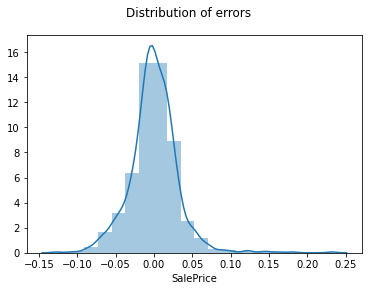

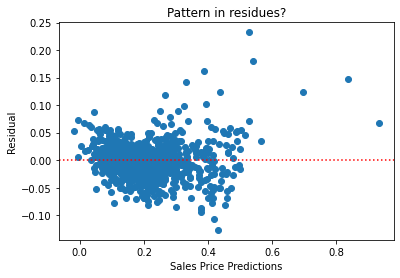

***Linear regression test data residual analysis***


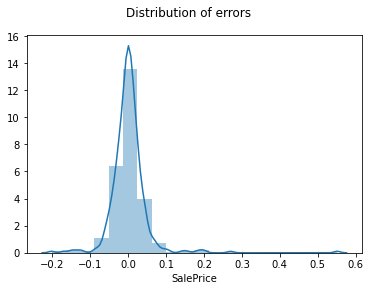

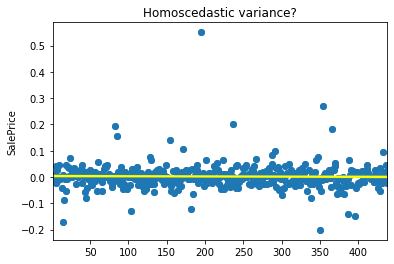

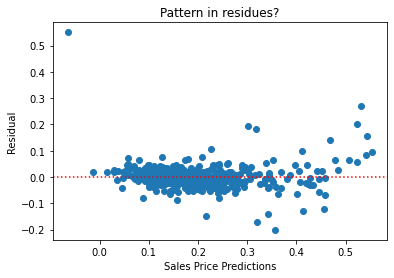

****Scores of Linear regression after RFE****
**********XTrain columns  40
**********XTest columns  40
Metrics
 {'R2Train': 0.9176444951117486, 'R2Test': 0.8096130955909544, 'RSSTrain': 1.013386831275504, 'RSSTest': 1.0349091740012297, 'MSETrain': 0.0009925434194667034, 'RMSETrain': 0.03150465710758813, 'MSETest': 0.002362806333336141, 'RMSETest': 0.04860870635324644}


In [33]:
X_train = X_train[X_train_rfe.columns]
X_test = X_test[X_train_rfe.columns]

postRFELM = LRFitAndAnalyze(X_train, y_train, X_test, y_test)

## Ridge Regression

In [34]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
                     0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 
                     1.9997, 1.9998, 1.9999, 2.0, 2.1111, 2.1112, 2.1113, 2.5, 3.0, 
                     4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html


Fitting 5 folds for each of 37 candidates, totalling 185 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 185 out of 185 | elapsed:    1.7s finished


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5,
                                   1.9997, 1.9998, 1.9999, 2.0, 2.1111, 2.1112,
                                   2.1113, 2.5, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [35]:
# Printing the best hyperparameter alpha
ridgeAlpha = model_cv.best_params_.get('alpha')
print('Ridge Regularization Alpha - ',  ridgeAlpha)

Ridge Regularization Alpha -  1.5


In [36]:
#Fits the X and y train using Ridge model and calculates scores and does residual analysis
def ridgeFitAndAnalyze(alpha, XTrain, yTrain, XTest, yTest):
    #Fitting Ridge model for alpha and printing coefficients which have been penalised
    print("Ridge alpha - ", alpha)
    ridge = Ridge(alpha = alpha)
    ridge.fit(XTrain, yTrain)
    print(ridge.coef_)
    print(len(ridge.coef_))
    
    results = predictAndDisplayScores(ridge, XTrain, yTrain, XTest, yTest, "****Scores of Ridge regularization****")

    YPredTrain = results.get('YPredTrain')
    YPredTest = results.get('YPredTest')
    metrics = results.get('metric')

    #print("Y Predicted train\n", YPredTrain)
    #print("Y Predicted test\n", YPredTest)
    print("Metrics\n", metrics)
    
    residualAnalysis(yTrain, YPredTrain, '***Ridge regularization residual analysis***')

    return ridge

#### Do the Ridge fit and prediction. Residuals are well behaved. 
#### 'R2Train': 0.89, 'R2Test': 0.86. Good accuracy, but we have 40 features!

Ridge alpha -  1.5
[-0.02983676  0.11350779  0.0381767   0.08657029  0.07403719  0.0356395
  0.11975112  0.12325555  0.05157032 -0.01981248  0.05448833  0.03668675
  0.06088016  0.02875292  0.0277364  -0.17601933 -0.02979246  0.03451405
  0.05261102  0.02282384  0.0185273   0.01820554  0.02186379  0.09891851
  0.02810296 -0.01743095 -0.04626998 -0.04706542 -0.05071539 -0.03846163
 -0.00875066  0.03312427  0.02075262 -0.0500085  -0.04563245 -0.05321049
 -0.02332114 -0.03552615  0.01798567  0.02618932]
40
****Scores of Ridge regularization****
**********XTrain columns  40
**********XTest columns  40
Metrics
 {'R2Train': 0.8875462133214658, 'R2Test': 0.8576148617471548, 'RSSTrain': 1.3837470452245197, 'RSSTest': 0.7739801551828889, 'MSETrain': 0.001355286038417747, 'RMSETrain': 0.03681420973507033, 'MSETest': 0.0017670779798696092, 'RMSETest': 0.042036626647122974}
***Ridge regularization residual analysis***


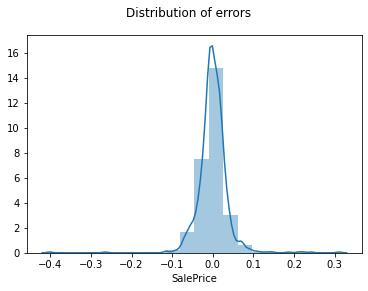

In [37]:
ridgeModel = ridgeFitAndAnalyze(ridgeAlpha, X_train, y_train, X_test, y_test)

### Lasso Regression

In [38]:
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
                     0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
                     4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    1.4s finished


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.2,
                                   0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0,
                                   3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20,
                                   50, 100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [39]:
# Printing the best hyperparameter alpha
lassoAlpha = model_cv.best_params_.get('alpha')
print('Lasso Regularization Alpha - ', lassoAlpha)

Lasso Regularization Alpha -  0.0001


In [40]:
#Fit and predict using Lasso and print scores and do residual analysis
def lassoFitAndAnalyze(alpha, XTrain, yTrain, XTest, yTest):
    #Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised
    print("Lasso alpha - ", alpha)
    lasso = Lasso(alpha=alpha)
    lasso.fit(XTrain, yTrain)
    
    print('Number of features selected ', np.count_nonzero(lasso.coef_))
    
    results = predictAndDisplayScores(lasso, XTrain, yTrain, XTest, yTest, "****Scores of Lasso regularization****")

    YPredTrain = results.get('YPredTrain')
    YPredTest = results.get('YPredTest')
    metrics = results.get('metric')

    #print("Y Predicted train\n", YPredTrain)
    #print("Y Predicted test\n", YPredTest)
    print("Metrics\n", metrics)
    
    residualAnalysis(y_train, YPredTrain, '***Lasso regularization residual analysis***')
    
    return lasso

#### 28 features selected with Lasso, well behaved residues and 'R2Train': 0.90, 'R2Test': 0.84.
#### Good accuracy and interpretability.

In [41]:
lassoModel = lassoFitAndAnalyze(lassoAlpha, X_train, y_train, X_test, y_test)

Lasso alpha -  0.0001
Number of features selected  28
****Scores of Lasso regularization****
**********XTrain columns  40
**********XTest columns  40
Metrics
 {'R2Train': 0.8916407888604706, 'R2Test': 0.8408529143986201, 'RSSTrain': 1.3333631766959901, 'RSSTest': 0.865095104180925, 'MSETrain': 0.0013059384688501373, 'RMSETrain': 0.03613777066796093, 'MSETest': 0.0019751029775820204, 'RMSETest': 0.04444213065979196}
***Lasso regularization residual analysis***


In [42]:
#Generates the betas for all 3 models
def getBetas(XTrain, linMod, ridMod, lasMod):
    betas = pd.DataFrame(index = XTrain.columns)
    betas.rows = XTrain.columns

    betas['Linear'] = linMod.coef_
    betas['Ridge'] = ridMod.coef_
    betas['Lasso'] = lasMod.coef_
    return betas


In [43]:
betas = getBetas(X_train, postRFELM, ridgeModel ,lassoModel)
pd.set_option('display.max_rows', None)
betas.head(200)

Linear     Ridge     Lasso
MSSubClass           -0.029984 -0.029837 -0.029752
OverallQual           0.112923  0.113508  0.125641
OverallCond           0.037114  0.038177  0.037029
YearBuilt             0.090699  0.086570  0.087396
BsmtFinSF1            0.089450  0.074037  0.076759
BsmtUnfSF             0.047150  0.035639  0.035728
1stFlrSF              0.330764  0.119751  0.166152
2ndFlrSF              0.350846  0.123256  0.170472
GrLivArea            -0.215747  0.051570 -0.000000
BedroomAbvGr         -0.027853 -0.019812 -0.023624
GarageArea            0.053822  0.054488  0.048492
Neighborhood_crawfor  0.035673  0.036687  0.032901
Neighborhood_noridge  0.048935  0.060880  0.054698
Neighborhood_stonebr  0.026660  0.028753  0.021049
Condition2_posa       0.076732  0.027736  0.000000
Condition2_posn      -0.571398 -0.176019 -0.365658
BldgType_duplex      -0.036020 -0.029792 -0.027607
RoofMatl_compshg      0.496308  0.034514  0.019358
RoofMatl_membran      0.619758  0.052611  0.000000
RoofMatl_metal        0.513750  0.022824  0.000000
RoofMatl_roll         0.511392  0.018527  0.000000
RoofMatl_tar&grv      0.494558  0.018206  0.000000
RoofMatl_wdshake      0.504672  0.021864  0.000000
RoofMatl_wdshngl      0.552684  0.098919  0.085638
Exterior1st_brkface   0.028154  0.028103  0.026103
Exterior1st_imstucc  -0.035866 -0.017431 -0.000000
BsmtQual_fa          -0.045986 -0.046270 -0.039910
BsmtQual_gd          -0.048836 -0.047065 -0.044084
BsmtQual_ta          -0.049731 -0.050715 -0.045945
BsmtCond_none        -0.033499 -0.038462 -0.029307
BsmtCond_po          -0.028390 -0.008751 -0.000000
BsmtExposure_gd       0.034071  0.033124  0.033433
Heating_wall          0.040059  0.020753  0.000000
KitchenQual_fa       -0.054707 -0.050009 -0.046782
KitchenQual_gd       -0.051847 -0.045632 -0.044245
KitchenQual_ta       -0.056818 -0.053210 -0.051051
Functional_mod       -0.045185 -0.023321 -0.009757
Functional_sev       -0.102453 -0.035526 -0.000000
GarageFinish_none     0.024280  0.017986  0.014832
SaleType_con          0.042757  0.026189  0.000000

In [44]:
#Get top 5 betas
def getTopBetas(betas):
    #Get the magnitude of the betas
    for col in betas.columns:
        betas[col] = betas[col].apply(abs)
    #Sort the features based on betas for each algorithm
    for col in betas.columns:
        print("****Printing by ", col, "****")
        betas = betas.sort_values(by=[col], ascending=False)
        print(betas[col].iloc[0:5])    
    return

In [45]:
getTopBetas(betas)

****Printing by  Linear ****
RoofMatl_membran    0.619758
Condition2_posn     0.571398
RoofMatl_wdshngl    0.552684
RoofMatl_metal      0.513750
RoofMatl_roll       0.511392
Name: Linear, dtype: float64
****Printing by  Ridge ****
Condition2_posn     0.176019
2ndFlrSF            0.123256
1stFlrSF            0.119751
OverallQual         0.113508
RoofMatl_wdshngl    0.098919
Name: Ridge, dtype: float64
****Printing by  Lasso ****
Condition2_posn    0.365658
2ndFlrSF           0.170472
1stFlrSF           0.166152
OverallQual        0.125641
YearBuilt          0.087396
Name: Lasso, dtype: float64


### Answers to questions in assignment part I
- ### Q1) Which variables are significant in predicting the price of a house?

#### The TOP 5 features impacting sales price by each algorithm (decided by the magnitude of the betas)
Linear Regression - 'R2Train': 0.92, 'R2Test': 0.81
- RoofMatl_membran    0.619758
- Condition2_posn     -0.571398
- RoofMatl_wdshngl    0.552684
- RoofMatl_metal      0.513750
- RoofMatl_roll       0.511392

Ridge Regularization - 'R2Train': 0.89, 'R2Test': 0.86, Best lambda - 1.5
- Condition2_posn     -0.176019
- 2ndFlrSF            0.123256
- 1stFlrSF            0.119751
- OverallQual         0.113508
- RoofMatl_wdshngl    0.098919

Lasso Regularization - 'R2Train': 0.90, 'R2Test': 0.84, Best lambda - 0.0001
- Condition2_posn    -0.365658
- 2ndFlrSF           0.170472
- 1stFlrSF           0.166152
- OverallQual        0.125641
- YearBuilt          0.087396

- ### Q2) How well those variables describe the price of a house?
- These are the variables that were arrived after applying RFE in Linear Regression, Ridge and Lasso Regularizations. 
- The R2 values for the 3 algorithms are listed above. Notice that these are pretty close ~5%, except for Linear Regression. LR accuracy was low due to the variance and we had to reduce it with regularization. 
- The Regularization algorithms have given reasonable accuracies in test data. The residual analysis for the 3 algorithms indicate homoscedasticity, no patterns in errors, errors are normally distributed around 0.

- ### Q3) Lambda for Ridge and Lasso - The lambdas for Ridge and Lasso are 1.5 and 0.0001 respectively.



### Code for questions in assignment part II

### Q1) What is the impact on top features if alpha is doubled for Ridge and Lasso?

Ridge alpha -  3.0
[-0.0287514   0.1114829   0.03591213  0.08255056  0.07227627  0.03412444
  0.09845103  0.09826223  0.07514732 -0.01498581  0.05525191  0.0353511
  0.06095771  0.02714261  0.01761166 -0.10546304 -0.02920667  0.01567421
  0.02721796  0.00973841  0.00671834  0.00049762  0.00632672  0.07039744
  0.02725205 -0.01078391 -0.04405068 -0.04554811 -0.05033853 -0.03702691
 -0.00637208  0.03363995  0.0138002  -0.04811282 -0.04393247 -0.05320318
 -0.01958587 -0.02226496  0.01568118  0.01856246]
40
****Scores of Ridge regularization****
**********XTrain columns  40
**********XTest columns  40
Metrics
 {'R2Train': 0.8805592668906057, 'R2Test': 0.8586261765069056, 'RSSTrain': 1.4697216198867538, 'RSSTest': 0.7684828289570245, 'MSETrain': 0.0014394922819654786, 'RMSETrain': 0.03794064155975065, 'MSETest': 0.0017545270067511973, 'RMSETest': 0.04188707445920755}
***Ridge regularization residual analysis***


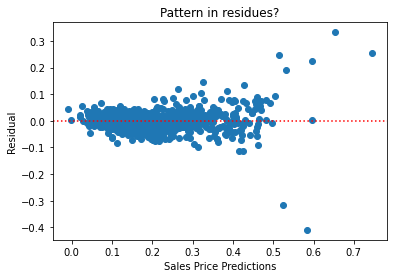

In [46]:
ridgeModel2 = ridgeFitAndAnalyze(ridgeAlpha*2, X_train, y_train, X_test, y_test)

In [47]:
lassoModel2 = lassoFitAndAnalyze(lassoAlpha*2, X_train, y_train, X_test, y_test)

Lasso alpha -  0.0002
Number of features selected  27
****Scores of Lasso regularization****
**********XTrain columns  40
**********XTest columns  40
Metrics
 {'R2Train': 0.8848948339625127, 'R2Test': 0.8491290389373518, 'RSSTrain': 1.4163723436878648, 'RSSTest': 0.8201075708372023, 'MSETrain': 0.0013872402974415914, 'RMSETrain': 0.037245674882348305, 'MSETest': 0.001872391714240188, 'RMSETest': 0.043271141818077646}
***Lasso regularization residual analysis***


In [48]:
betas = getBetas(X_train, postRFELM, ridgeModel2 ,lassoModel2)
pd.set_option('display.max_rows', None)
betas.head(200)
getTopBetas(betas)

****Printing by  Linear ****
RoofMatl_membran    0.619758
Condition2_posn     0.571398
RoofMatl_wdshngl    0.552684
RoofMatl_metal      0.513750
RoofMatl_roll       0.511392
Name: Linear, dtype: float64
****Printing by  Ridge ****
OverallQual        0.111483
Condition2_posn    0.105463
1stFlrSF           0.098451
2ndFlrSF           0.098262
YearBuilt          0.082551
Name: Ridge, dtype: float64
****Printing by  Lasso ****
Condition2_posn    0.247190
1stFlrSF           0.161111
2ndFlrSF           0.156739
OverallQual        0.137956
YearBuilt          0.083046
Name: Lasso, dtype: float64


### Q3) What if top 5 features are missing in the data? 
#### We remove the features in test and train data, rebuild the RFE Linear model, regularize with Lasso and then pick the top 5 features.

In [49]:
from sklearn.model_selection import train_test_split

#Top 5 from Lasso model
removeCols = ['Condition2_posn', '1stFlrSF', '2ndFlrSF','OverallQual', 'YearBuilt']
housingDF.drop(removeCols, inplace=True, axis=1)

In [50]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(housingDF, train_size = 0.7, test_size = 0.3, random_state = 100)

numericCols2Scale = list(set(numericCols2Scale).difference(set(removeCols)))

In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Apply scaler() to all the Feature - X vars (that are numeric)
#Train data scaling
df_train[numericCols2Scale] = scaler.fit_transform(df_train[numericCols2Scale])
#Test data scaling
df_test[numericCols2Scale] = scaler.transform(df_test[numericCols2Scale])

#Separate train data features and target (X and y)
y_train = df_train.pop('SalePrice')
X_train = df_train

#Separate test data features and target (X and y)
y_test = df_test.pop('SalePrice')
X_test = df_test

In [52]:
# Running RFE with the output number of the variable equal to 10
rfeLM = LinearRegression()
rfeLM.fit(X_train, y_train)

TOP_N_COLUMNS = 40
rfe = RFE(rfeLM, TOP_N_COLUMNS)
rfe = rfe.fit(X_train, y_train)

list(zip(X_train.columns,rfe.support_,rfe.ranking_))

#There are TOP_N_COLUMNS columns that RFE has 'favourably' supported.
col = X_train.columns[rfe.support_]
col

# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [53]:
dropColumns = []

In [54]:
#REMOVE top VIF columns iteratively
X_train_rfe = X_train_rfe.drop(dropColumns, axis = 1)
toDelColumn, rfeLM = doRFEAndReturnTopVIFColumn(y_train, X_train_rfe)
dropColumns = [toDelColumn]
print('**** Feature with TOP VIF is ', toDelColumn, ' ****')
print('**** To drop ', toDelColumn, ' and do VIF run this cell again ***')

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     162.1
Date:                Mon, 22 Feb 2021   Prob (F-statistic):               0.00
Time:                        23:04:09   Log-Likelihood:                 1843.5
No. Observations:                1021   AIC:                            -3605.
Df Residuals:                     980   BIC:                            -3403.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5355 

In [55]:
print(X_train_rfe.columns)
print(len(X_train_rfe.columns))

X_train = X_train[X_train_rfe.columns]
X_test = X_test[X_train_rfe.columns]

Index(['BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'FullBath', 'GarageArea',
       'MSZoning_fv', 'MSZoning_rh', 'MSZoning_rl', 'MSZoning_rm',
       'Neighborhood_noridge', 'Condition2_feedr', 'Condition2_norm',
       'Condition2_posa', 'Condition2_rran', 'Condition2_rrnn',
       'BldgType_duplex', 'RoofStyle_shed', 'RoofMatl_compshg',
       'RoofMatl_membran', 'RoofMatl_metal', 'RoofMatl_roll',
       'RoofMatl_tar&grv', 'RoofMatl_wdshake', 'RoofMatl_wdshngl',
       'Exterior1st_imstucc', 'Exterior2nd_cblock', 'Exterior2nd_imstucc',
       'BsmtQual_fa', 'BsmtQual_gd', 'BsmtQual_none', 'BsmtQual_ta',
       'Heating_othw', 'KitchenQual_fa', 'KitchenQual_gd', 'KitchenQual_ta',
       'Functional_sev', 'Functional_typ', 'GarageCond_gd', 'SaleType_con',
       'SaleCondition_alloca'],
      dtype='object')
40


***Linear regression training data residual analysis***


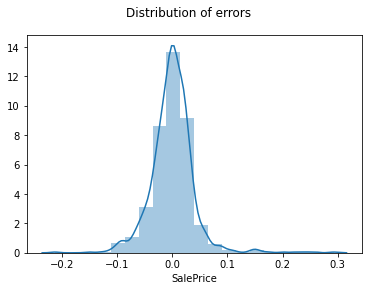

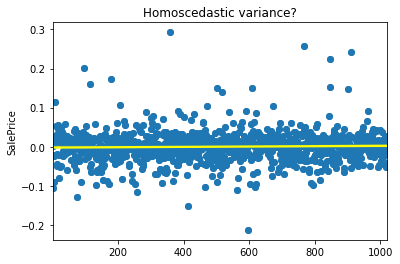

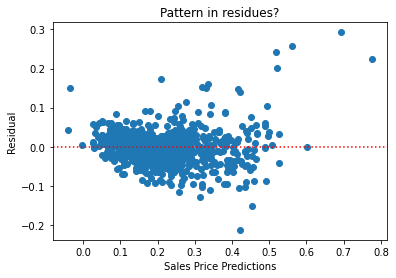

***Linear regression test data residual analysis***


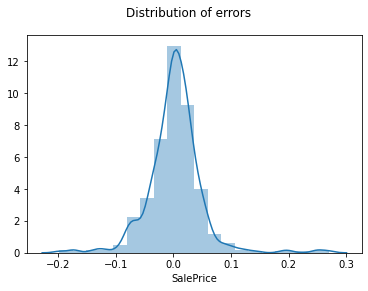

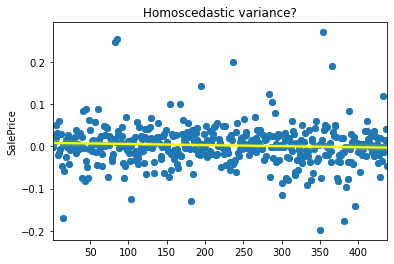

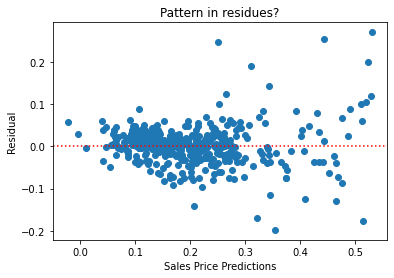

****Scores of Linear regression after RFE****
**********XTrain columns  40
**********XTest columns  40
Metrics
 {'R2Train': 0.8687341276719681, 'R2Test': 0.8175836701827782, 'RSSTrain': 1.6152302944850967, 'RSSTest': 0.9915825555410811, 'MSETrain': 0.0015820081238835423, 'RMSETrain': 0.03977446572719164, 'MSETest': 0.0022638871131074913, 'RMSETest': 0.04758032275119087}


In [56]:
postRFELM = LRFitAndAnalyze(X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 145 out of 145 | elapsed:    1.4s finished


Lasso Regularization Alpha -  0.0001
Lasso alpha -  0.0001
Number of features selected  26
****Scores of Lasso regularization****
**********XTrain columns  40
**********XTest columns  40
Metrics
 {'R2Train': 0.8432688605425003, 'R2Test': 0.821265934897152, 'RSSTrain': 1.9285811311891186, 'RSSTest': 0.9715664228882854, 'MSETrain': 0.0018889139384810172, 'RMSETrain': 0.04346163754946444, 'MSETest': 0.002218188180110241, 'RMSETest': 0.04709764516523348}
***Lasso regularization residual analysis***


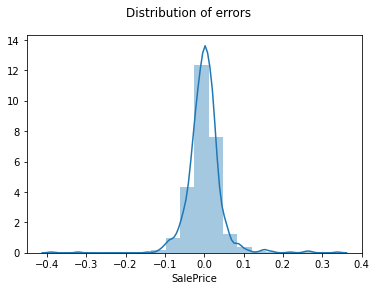

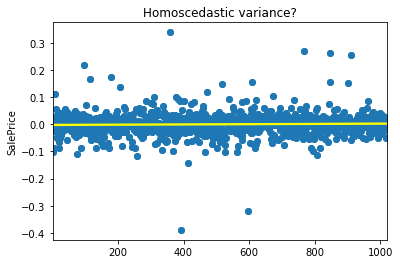

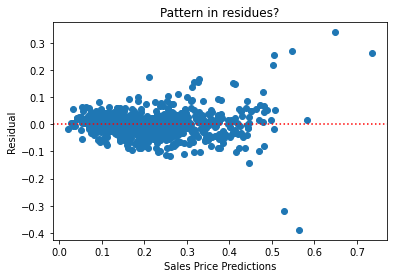

In [57]:
params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 
                     0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
                     4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

lasso = Lasso()
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train)

# Printing the best hyperparameter alpha
lassoAlpha = model_cv.best_params_.get('alpha')
print('Lasso Regularization Alpha - ', lassoAlpha)


lassoModel = lassoFitAndAnalyze(lassoAlpha, X_train, y_train, X_test, y_test)

In [58]:
betas = pd.DataFrame(index = X_train.columns)
betas.rows = X_train.columns

betas['Lasso'] = lassoModel.coef_
pd.set_option('display.max_rows', None)
betas.head(200)


Lasso
BsmtFinSF1            0.047114
TotalBsmtSF           0.108552
GrLivArea             0.189910
FullBath              0.028746
GarageArea            0.057403
MSZoning_fv           0.024111
MSZoning_rh           0.000000
MSZoning_rl           0.015202
MSZoning_rm           0.000000
Neighborhood_noridge  0.066418
Condition2_feedr      0.003374
Condition2_norm       0.037692
Condition2_posa       0.013114
Condition2_rran       0.000000
Condition2_rrnn       0.000000
BldgType_duplex      -0.049844
RoofStyle_shed        0.000000
RoofMatl_compshg      0.000000
RoofMatl_membran      0.031171
RoofMatl_metal        0.000000
RoofMatl_roll        -0.000000
RoofMatl_tar&grv      0.000000
RoofMatl_wdshake      0.000000
RoofMatl_wdshngl      0.117735
Exterior1st_imstucc  -0.000000
Exterior2nd_cblock   -0.000000
Exterior2nd_imstucc   0.018915
BsmtQual_fa          -0.070458
BsmtQual_gd          -0.057905
BsmtQual_none        -0.041077
BsmtQual_ta          -0.077302
Heating_othw         -0.000000
KitchenQual_fa       -0.082891
KitchenQual_gd       -0.056009
KitchenQual_ta       -0.077129
Functional_sev       -0.000000
Functional_typ        0.035275
GarageCond_gd        -0.020403
SaleType_con          0.021152
SaleCondition_alloca  0.014442

In [59]:
getTopBetas(betas)

****Printing by  Lasso ****
GrLivArea           0.189910
RoofMatl_wdshngl    0.117735
TotalBsmtSF         0.108552
KitchenQual_fa      0.082891
BsmtQual_ta         0.077302
Name: Lasso, dtype: float64


### END OF FILE